In [1]:
import os
os.chdir(os.getcwd() + "/HLP_Project/")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from heapq import heappush, heappop

from libs.cython.pyx.edgelistParser import edgelistParser
from libs.cython.pyx.utils import list2matrix
from libs.cython.cpp.pageRankCpp import cppApproximateSimrank

In [3]:
# dataset paths
datasets = [
    "../datasets/facebook/3980.edges",
    "../datasets/facebook/698.edges",
    "../datasets/facebook/414.edges",
    "../datasets/facebook/686.edges",
    "../datasets/facebook/348.edges",
    "../datasets/facebook/0.edges",
    "../datasets/facebook/3437.edges",
    "../datasets/facebook/1912.edges",
    "../datasets/facebook/1684.edges",
    "../datasets/facebook/107.edges",
    "../datasets/facebook_combined.txt",
    "../datasets/Wiki-Vote.txt",
    "../datasets/CA-HepPh.txt",
    "../datasets/Email-Enron.txt",
    "../datasets/p2p-Gnutella31.txt",
    "../datasets/Email-EuAll.txt",
    "../datasets/com-dblp.ungraph.txt"
]

# dataset types
list_types = ["raw_list"]*10 + [
    "list",
    "list",
    "raw_list",
    "raw_list",
    "list",
    "list",
    "list"
]

In [4]:
# load the dataset
idx = 3
dataset = datasets[idx]
list_type = list_types[idx]
A, N, original_idxs = edgelistParser(dataset, list_type, False)
A_w, _, _ = edgelistParser(dataset, list_type, True)
A_mat = list2matrix(A_w)
print("N =", N)

N = 168


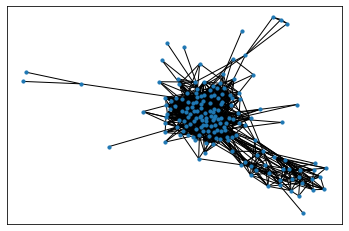

In [5]:
# plot the loaded dataset
g = nx.Graph(A_mat)
plt.figure()
nx.draw_networkx(g, node_size=10, with_labels=False)
plt.show()

In [6]:
def push(p, r, u, neighbors, alpha):
    # set the helper variables
    r_u = r[u]
    d_u = len(neighbors)
    
    # update p and r
    p[u] = p[u] + alpha*r_u
    r[u] = (1 - alpha)*r_u/2
    
    # for each neighbor of u update r
    for v in neighbors:
        r[v] = r[v] + (1 - alpha)*r_u/(2*d_u)

In [7]:
def approximate_page_rank(A, v, alpha, epsilon):
    # initialize the distributions
    N = len(A)
    p = np.zeros(N)
    r = np.zeros(N)
    r[v] = 1
    
    # initialize the helper queue
    h = []
    key = r[v]/len(A[v])
    if key>=epsilon:
        heappush(h, (- key, v))
    
    # perform the push operations
    while len(h)>0:
        u = heappop(h)[1]
        neighbors = A[u]
        push(p, r, u, neighbors, alpha)
        
        # add the new nodes to the queue
        key = r[u]/len(neighbors)
        if key>=epsilon:
            heappush(h, (- key, u))
        for node in neighbors:
            key = r[node]/len(A[node])
            if key>=epsilon:
                heappush(h, (- key, node))
                
    # return the approximate PageRank
    return p, r

In [8]:
def page_rank(A, A_mat, N, s, alpha):
    s = s.reshape(1, N)
    I = np.eye(N)
    d_inv = np.zeros(N)
    for i in range(N):
        d_inv[i] = len(A[i])**(- 1)
    D_inv = np.diag(d_inv)
    W = 1/2*(I + np.dot(D_inv, A_mat))
    p = alpha*np.dot(s, np.linalg.inv(I - (1 - alpha)*W))
    return p.reshape(N)

In [9]:
# set the PageRank parameters
v = 0
alpha = 0.15
epsilon = 1e-3

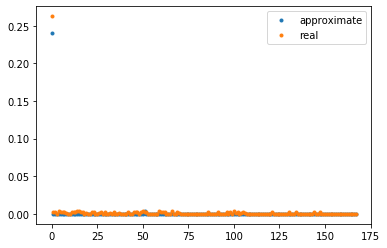

In [10]:
# compute Approximate PageRank
p, r = approximate_page_rank(A, v, alpha, epsilon)

# compute PageRank
s = np.zeros((1, N))
s[0,v] = 1
pr = page_rank(A, A_mat, N, s, alpha)

# plot the results
plt.figure()
plt.plot(range(N), p, ".")
plt.plot(range(N), pr, ".")
plt.legend(["approximate", "real"])
plt.show()

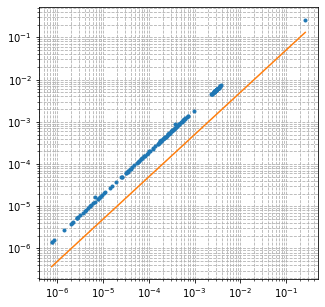

In [11]:
# check correctness
x = np.linspace(np.min(pr), np.max(pr))
y = 1/2*x
plt.figure(figsize=(5, 5))
plt.loglog(pr, p + page_rank(A, A_mat, N, r, alpha), ".")
plt.loglog(x,y)
plt.grid(True, which="both", ls="--")
plt.show()

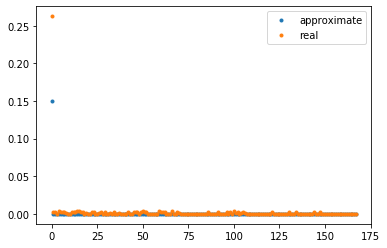

In [12]:
# compute Approximate PageRank
p, r = cppApproximateSimrank(A, v, alpha, epsilon, return_only_neighbours=False)

# plot the results
plt.figure()
plt.plot(range(N), p, ".")
plt.plot(range(N), pr, ".")
plt.legend(["approximate", "real"])
plt.show()

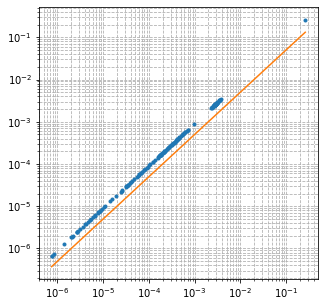

In [13]:
# check correctness
plt.figure(figsize=(5, 5))
plt.loglog(pr, p + page_rank(A, A_mat, N, np.array(r), alpha), ".")
plt.loglog(x,y)
plt.grid(True, which="both", ls="--")
plt.show()